## Import Data and Libraries

In [1]:
# Import libraries
import warnings
import itertools
# import seaborn as sns
from cryptory import Cryptory
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
plt.style.use('fivethirtyeight')

dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%y')

import warnings
warnings.filterwarnings("ignore")

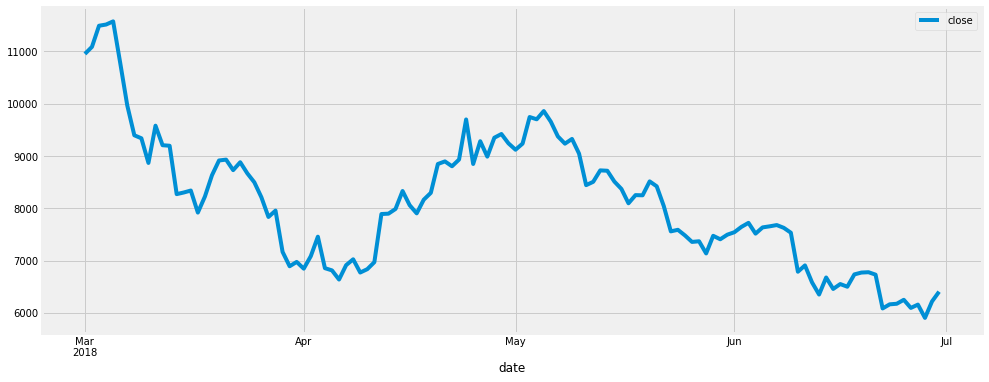

In [2]:
# Load Training Dataset and Plot the Historical Data
df_train_startdate = '2018-03-01'
df_train_raw = pd.read_csv('bitcoin_train.csv', parse_dates=['date'], index_col='date', date_parser=dateparse)
df_train = df_train_raw[df_train_startdate:].loc[:, ['close']]

df_train.plot(figsize=(15,6))
plt.show()

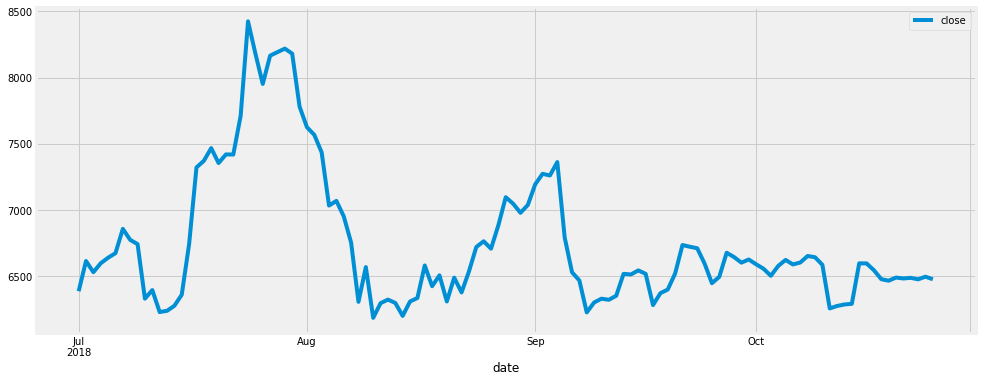

In [7]:
# Load Test Dataset and Plot The Test Dataset
my_cryptory = Cryptory(from_date = "2018-07-01")
df_test = my_cryptory.extract_coinmarketcap("bitcoin")
df_test = df_test.set_index('date').loc[:, ['close']]

df_test.plot(figsize=(15, 6))
plt.show()

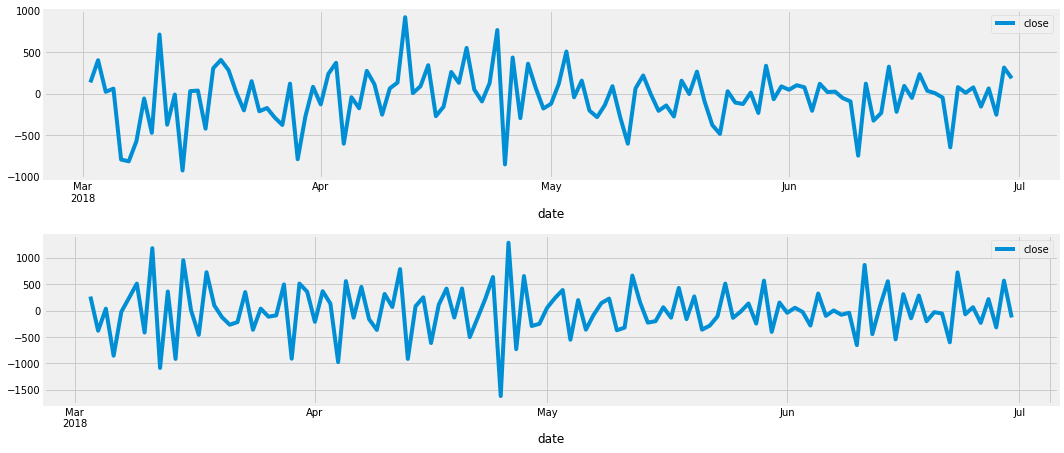

In [4]:
# Plot the Test Dataset Diff
df_train_diff1 = df_train.diff(1)
df_train_diff2 = df_train_diff1.diff(1)

fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()
df_train_diff1.plot(ax=ax1)

ax2 = fig.add_subplot(2, 1, 2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
df_train_diff2.plot(ax=ax2)

plt.show()

### Autocorrelation Plots

In [6]:
df_train

,close
date,
2018-03-01,10951.00
2018-03-02,11086.40
2018-03-03,11489.70
2018-03-04,11512.60
2018-03-05,11573.30
2018-03-06,10779.90
2018-03-07,9965.57
2018-03-08,9395.01
2018-03-09,9337.55


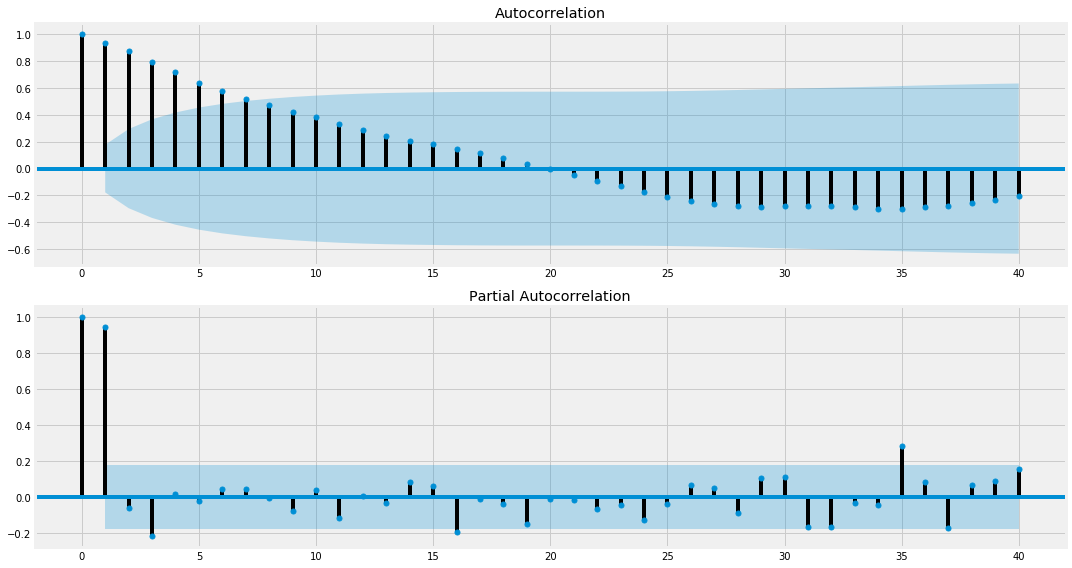

In [4]:
# Plot the Autocorrelation and Partial-Autocorrelation of the bitcoin prices
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(2, 1, 1)
fig = sm.graphics.tsa.plot_acf(df_train, lags=40, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(2, 1, 2)
fig = sm.graphics.tsa.plot_pacf(df_train, lags=40, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()

### Parameters Tuning

In [6]:
# Setup the test set and training set for time series method
ts_test = df_test.iloc[::-1]
ts_train = pd.concat([df_train, ts_test])
ts_train_strict = df_train

In [79]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(4, 7)
d = range(1, 3)
q = range(1, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# print('Examples of parameter combinations for Seasonal ARIMA...')
# for index, item in enumerate(pdq):
#     print('SARIMAX: {} x {}'.format(pdq[index], seasonal_pdq[index]))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(ts_train_strict,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(4, 1, 1)x(4, 1, 1, 12)12 - AIC:831.4522219157196
ARIMA(4, 1, 1)x(4, 1, 2, 12)12 - AIC:831.2560762757441
ARIMA(4, 1, 1)x(4, 2, 1, 12)12 - AIC:655.7453774042954
ARIMA(4, 1, 1)x(4, 2, 2, 12)12 - AIC:697.7671164180575
ARIMA(4, 1, 1)x(5, 1, 1, 12)12 - AIC:628.6636909600861
ARIMA(4, 1, 1)x(5, 1, 2, 12)12 - AIC:633.0947800806026
ARIMA(4, 1, 1)x(5, 2, 1, 12)12 - AIC:516.8425827706717
ARIMA(4, 1, 1)x(5, 2, 2, 12)12 - AIC:519.1513115241605
ARIMA(4, 1, 1)x(6, 1, 1, 12)12 - AIC:489.92327477902984
ARIMA(4, 1, 1)x(6, 1, 2, 12)12 - AIC:491.2437213011525
ARIMA(4, 1, 1)x(6, 2, 1, 12)12 - AIC:338.27395200471176
ARIMA(4, 1, 1)x(6, 2, 2, 12)12 - AIC:339.98493093742303
ARIMA(4, 1, 2)x(4, 1, 1, 12)12 - AIC:825.209561365018
ARIMA(4, 1, 2)x(4, 1, 2, 12)12 - AIC:826.7630536836298
ARIMA(4, 1, 2)x(4, 2, 1, 12)12 - AIC:692.9551792775462
ARIMA(4, 1, 2)x(4, 2, 2, 12)12 - AIC:694.2779685861352
ARIMA(4, 1, 2)x(5, 1, 1, 12)12 - AIC:651.9538630389377
ARIMA(4, 1, 2)x(5, 1, 2, 12)12 - AIC:656.197564774585
ARIMA(4, 

### Prediction

In [8]:
# Do the prediction with time series cross validation

pred_df = pd.DataFrame()

start_date = '2018-07-01'
ts_train_real = ts_train[:start_date]
mod = sm.tsa.statespace.SARIMAX(ts_train_real, 
                                order=(6, 2, 2), 
                                seasonal_order=(6, 2, 1, 12), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)
results = mod.fit()
pred = results.get_prediction(start=pd.to_datetime('2018-07-01'), dynamic=False)
pred_ci = pred.conf_int()
pred_df = pred_df.append(pred_ci)

def ts_cross_validation(ts_train, ts_test, pred_df):
    for i, start_date in enumerate(ts_test.index.get_values()):
        if(i < len(ts_test.index.get_values())):
            end_date = ts_test.index.get_values()[i]
            ts_train_real = ts_train[:start_date]
            mod = sm.tsa.statespace.SARIMAX(ts_train_real, 
                                        order=(5, 2, 1), 
                                        seasonal_order=(5, 2, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
            results = mod.fit()
            pred = results.get_prediction(start=pd.to_datetime(end_date), dynamic=False)
            pred_ci = pred.conf_int()
            pred_df = pred_df.append(pred_ci)
            print(end_date)
    
    return pred_df

pred_df = ts_cross_validation(ts_train, ts_test, pred_df)  

# Save Result
# pred_df.to_json('./predicted.csv')

2018-07-01T00:00:00.000000000
2018-07-02T00:00:00.000000000
2018-07-03T00:00:00.000000000
2018-07-04T00:00:00.000000000
2018-07-05T00:00:00.000000000
2018-07-06T00:00:00.000000000
2018-07-07T00:00:00.000000000
2018-07-08T00:00:00.000000000
2018-07-09T00:00:00.000000000
2018-07-10T00:00:00.000000000
2018-07-11T00:00:00.000000000
2018-07-12T00:00:00.000000000
2018-07-13T00:00:00.000000000
2018-07-14T00:00:00.000000000
2018-07-15T00:00:00.000000000
2018-07-16T00:00:00.000000000
2018-07-17T00:00:00.000000000
2018-07-18T00:00:00.000000000
2018-07-19T00:00:00.000000000
2018-07-20T00:00:00.000000000
2018-07-21T00:00:00.000000000
2018-07-22T00:00:00.000000000
2018-07-23T00:00:00.000000000
2018-07-24T00:00:00.000000000
2018-07-25T00:00:00.000000000
2018-07-26T00:00:00.000000000
2018-07-27T00:00:00.000000000
2018-07-28T00:00:00.000000000
2018-07-29T00:00:00.000000000
2018-07-30T00:00:00.000000000
2018-07-31T00:00:00.000000000
2018-08-01T00:00:00.000000000
2018-08-02T00:00:00.000000000
2018-08-03

In [10]:
pred_df

,lower close,upper close
2018-07-01,5112.407186,7653.500373
2018-07-01,5427.005424,7050.473840
2018-07-02,5344.221596,7157.657933
2018-07-03,5858.065170,7267.873037
2018-07-04,5159.244882,7503.541498
2018-07-05,5229.319231,7689.175227
2018-07-06,6035.158634,8353.592314
2018-07-07,5868.652830,8096.711596
2018-07-08,5815.893530,7946.036391
2018-07-09,6530.667375,7863.134937


The Root Mean Squared Error of our forecasts is 260.75


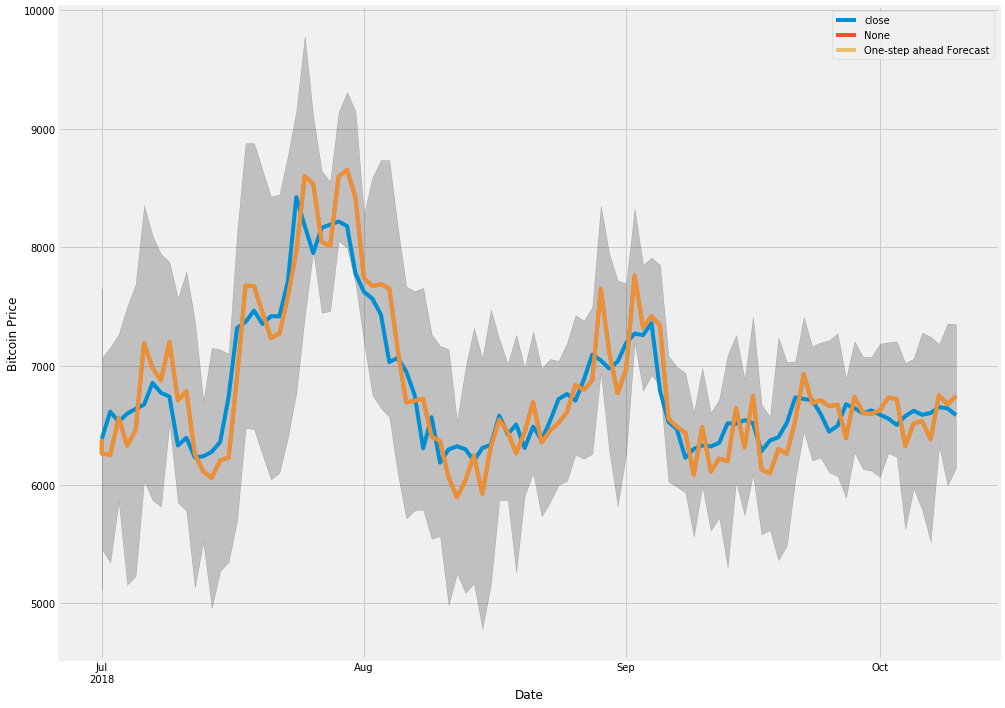

In [83]:
# Load the Prediction result from file system
# pred_df = pd.read_csv('./predicted.csv', sep=',', parse_dates=['date'], index_col='date')
       
pred_mean = (pred_df['upper close'] + pred_df['lower close'])/2
y_forecasted = pred_mean

# Compute the mean square error
mse = ((y_forecasted - ts_test.iloc[:,0]) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# # Plot the Graph
ax = ts_test.plot(label='observed')
pred_mean.plot(figsize=(15, 12))
pred_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_df.index,
                pred_df['lower close'],
                pred_df['upper close'], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin Price')
plt.legend()

plt.show()



In [ ]:
# Output prediction to csv file
output = {'Y_pred': y_forecasted.reshape(-1,)}
output = DataFrame(output)
output.to_csv('ARIMA.csv', index=False)
